In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae

# for CVXPY implementation
from solardatatools.signal_decompositions import l1_l2d2p365 as cvx_sd

# for OSD implementation
from solardatatools.osd_signal_decompositions import l1_l2d2p365 as osd_sd

# Import data from `tests/fixtures`

In [2]:
# Import data
fixtures_path = "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/"

data_file_path = Path(fixtures_path + "clear_day_detection/one_year_power_signals_1.csv")

with open(data_file_path) as file:
    data = np.loadtxt(file, delimiter=",")
expected_data_file_path = Path(fixtures_path + "clear_day_detection/one_year_weights_1.csv")

with open(expected_data_file_path) as file:
    expected_output = np.loadtxt(file, delimiter=",")

## Preprocess data to obtain metric

In [3]:
daily_sparsity = np.sum(data > 0.005 * np.max(data), axis=0)

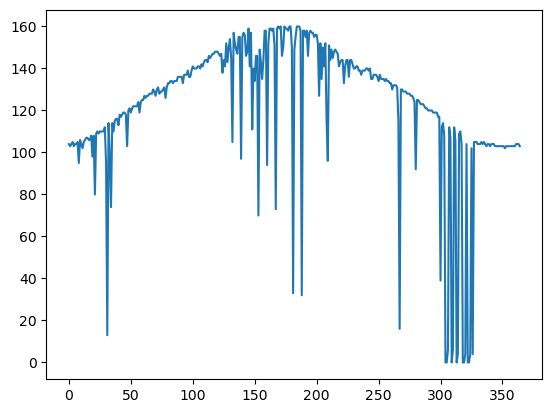

In [4]:
plt.plot(daily_sparsity);

# Run tests

## Compare CVXPY/OSD with identical weights

### With MOSEK/QSS

CVXPY objective       3303.95276
OSD objective, scaled 3303.96709
MAE (OSD,CVX)   2.30e-04


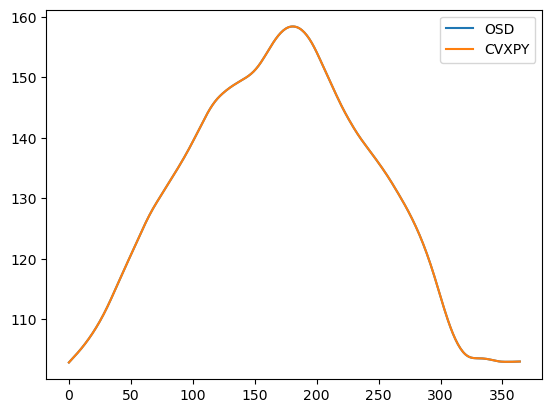

In [5]:
cvx_t1 = cvx_sd(daily_sparsity, c1=1e3, yearly_periodic=False, solver="MOSEK")
osd_t1 = osd_sd(daily_sparsity, w2=1e3, yearly_periodic=False, solver="QSS")

# get scaled obj from cvxpy
cvx_sd(daily_sparsity, c1=1e3, yearly_periodic=False, solver="MOSEK", comp_osd=osd_t1)
print(f'MAE (OSD,CVX)   {mae(cvx_t1, osd_t1):.2e}')

f, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(osd_t1, label="OSD")
ax1.plot(cvx_t1, label="CVXPY")
ax1.legend()
plt.show()

### With MOSEK/MOSEK

CVXPY objective       3303.95276
OSD objective, scaled 3303.95276
MAE (OSD,CVX)   0.00e+00


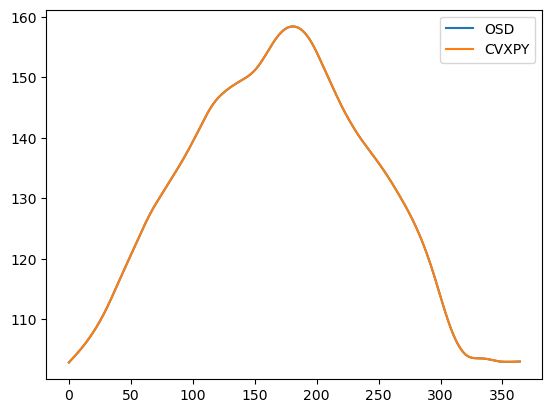

In [6]:
cvx_t1 = cvx_sd(daily_sparsity, c1=1e3, yearly_periodic=False, solver="MOSEK")
osd_t1 = osd_sd(daily_sparsity, w2=1e3, yearly_periodic=False, solver="MOSEK")

# get scaled obj from cvxpy
cvx_sd(daily_sparsity, c1=1e3, yearly_periodic=False, solver="MOSEK", comp_osd=osd_t1)
print(f'MAE (OSD,CVX)   {mae(cvx_t1, osd_t1):.2e}')

f, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(osd_t1, label="OSD")
ax1.plot(cvx_t1, label="CVXPY")
ax1.legend()
plt.show()

## Compare CVXPY/OSD, doubling weight for OSD

CVXPY objective       3303.95276
OSD objective, scaled 122507.39190
MAE (OSD,CVX)   8.72e-04


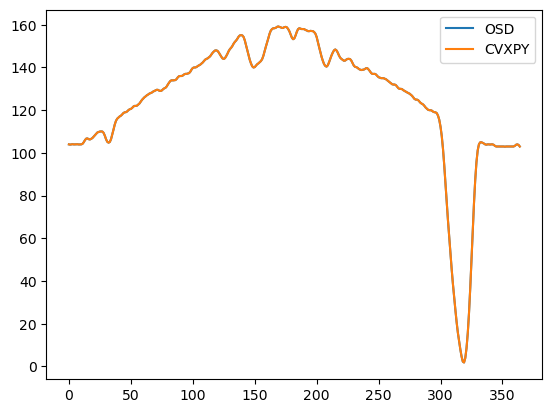

In [18]:
cvx_t1 = cvx_sd(daily_sparsity, c1=1e3*.001, yearly_periodic=False, solver="MOSEK")
osd_t1 = osd_sd(daily_sparsity, w2=2*1e3*.001, yearly_periodic=False, solver="QSS")

# get scaled obj from cvxpy
cvx_sd(daily_sparsity, c1=1e3, yearly_periodic=False, solver="MOSEK", comp_osd=osd_t1)
print(f'MAE (OSD,CVX)   {mae(cvx_t1, osd_t1):.2e}')

f, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(osd_t1, label="OSD")
ax1.plot(cvx_t1, label="CVXPY")
ax1.legend()
plt.show()

## Doubling length to make it 2 years

In [11]:
data_long = np.array(list(daily_sparsity) + list(daily_sparsity))

CVXPY objective       6610.07146
OSD objective, scaled 6697.57187
MAE (OSD,CVX)   3.60e-01


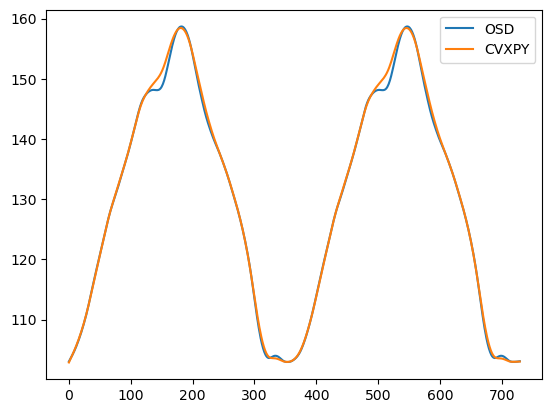

In [12]:
cvx_t2 = cvx_sd(data_long, c1=1e3, yearly_periodic=False, solver="MOSEK")
osd_t2 = osd_sd(data_long, w2=1e3, yearly_periodic=False, solver="QSS")

# get scaled obj from cvxpy
cvx_sd(data_long, c1=1e3, yearly_periodic=False, solver="MOSEK", comp_osd=osd_t2)
print(f'MAE (OSD,CVX)   {mae(cvx_t2, osd_t2):.2e}')

f, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(osd_t2, label="OSD")
ax1.plot(cvx_t2, label="CVXPY")
ax1.legend()
plt.show()

### Adding periodicity

CVXPY objective       6611.91428
OSD objective, scaled 6611.91453
MAE (OSD,CVX)   1.58e-04


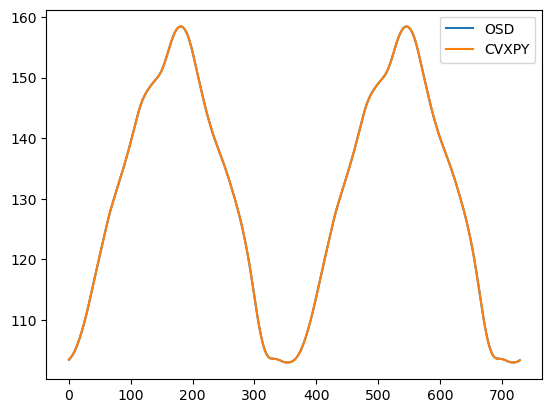

In [13]:
cvx_t2 = cvx_sd(data_long, c1=1e3, yearly_periodic=True, solver="MOSEK")
osd_t2 = osd_sd(data_long, w2=2e3, yearly_periodic=True, solver="QSS")

# get scaled obj from cvxpy
cvx_sd(data_long, c1=1e3, yearly_periodic=True, solver="MOSEK", comp_osd=osd_t2)
print(f'MAE (OSD,CVX)   {mae(cvx_t2, osd_t2):.2e}')

f, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(osd_t2, label="OSD")
ax1.plot(cvx_t2, label="CVXPY")
ax1.legend()
plt.show()